In [1]:
import pandas as pd

df_all = pd.read_csv('df_all_from_partb.csv')

# Now df_all is ready for optimization/plotting as in your code


# COMPLETE WATER HEATER OPTIMIZATION SYSTEM

This file contains everything in the correct order:
1. Day-ahead optimization
2. Visualization


WATER HEATER OPTIMIZATION & CONTROL SYSTEM

PART 1: Running Day-Ahead Optimization
✓ Loaded 96 rows from df_all_from_partb.csv
✓ Identified 3 peak intervals where boiler will be disabled
✓ Starting optimization...
✓ Solver status: Optimal
✓ Total optimized cost: 14.61 SEK
✓ Total slack (unmet demand): 0.0000 kWh
✓ Saved: boiler_lp_15min_results_w_fallback.csv

PART 2: Generating Visualization
✓ Saved visualization: water_heater_optimization_visualization.png

OPTIMIZATION SUMMARY
Total Cost: 14.61 SEK
Total Grid Energy: 26.19 kWh
Total Boiler Energy Input: 26.19 kWh
Total Hot Water Demand: 19.89 kWh
Average Tank Level: 12.03 kWh
Max Tank Level: 19.03 kWh
Min Tank Level: 6.54 kWh
Total Unmet Demand: 0.0000 kWh


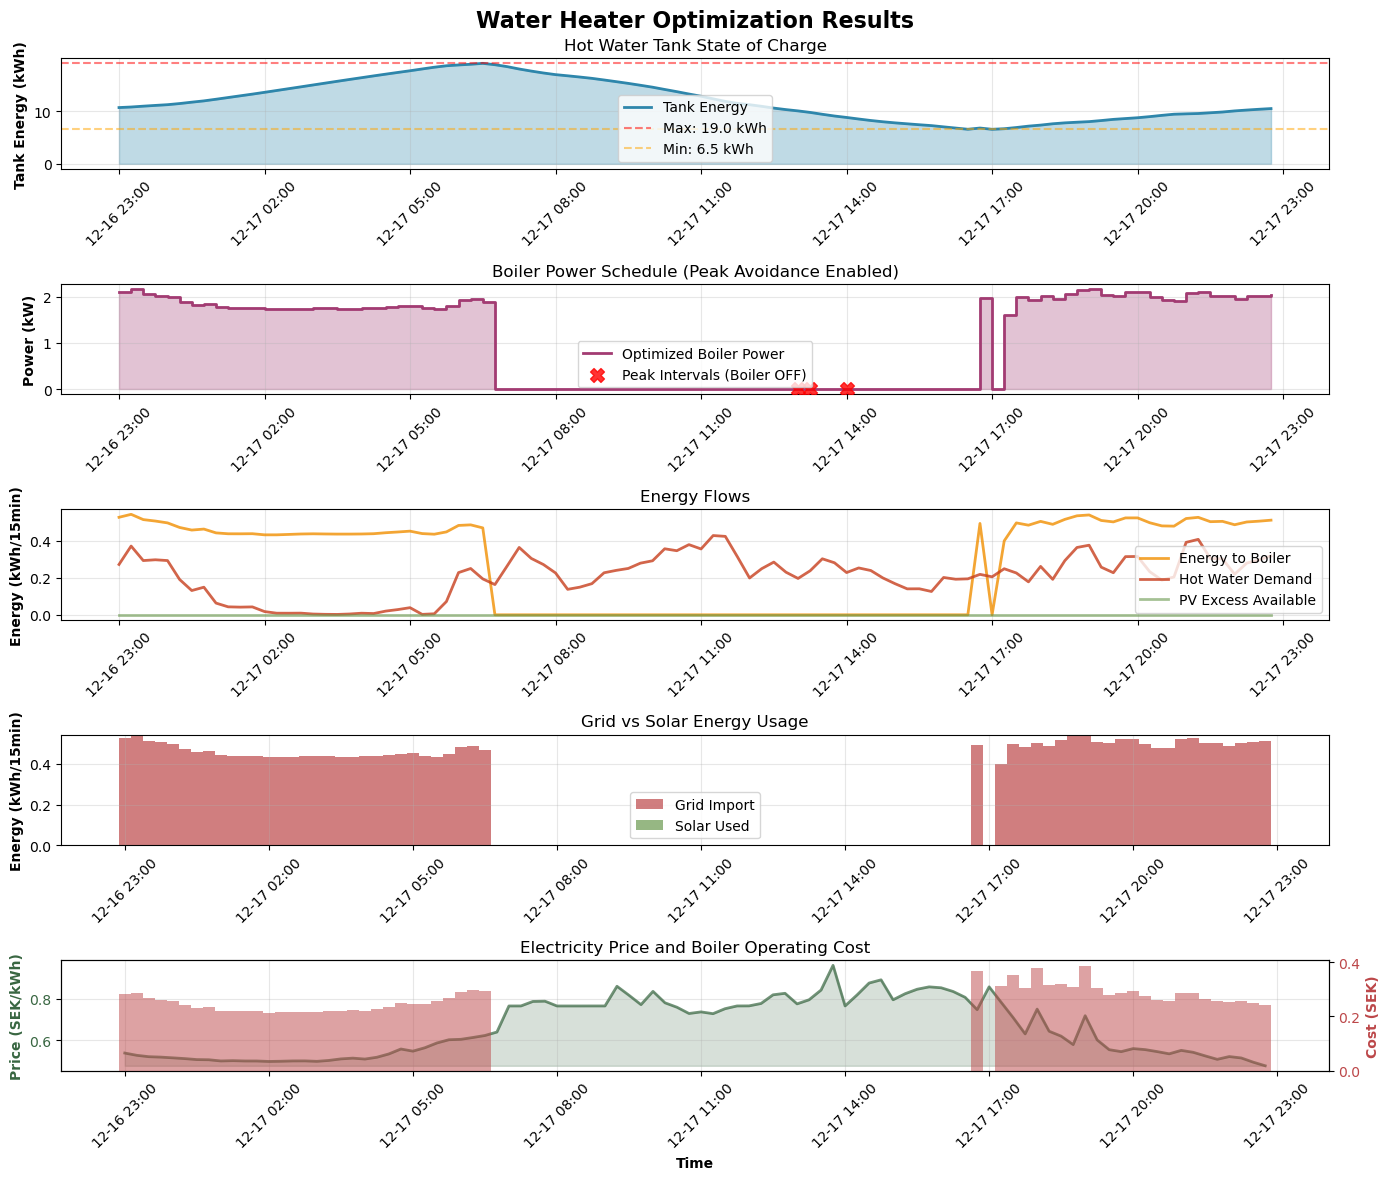

In [2]:

import numpy as np
import pandas as pd
import pulp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

print("="*70)
print("WATER HEATER OPTIMIZATION & CONTROL SYSTEM")
print("="*70)

# ============================================================================
# PART 1: DAY-AHEAD OPTIMIZATION
# ============================================================================

print("\n" + "="*70)
print("PART 1: Running Day-Ahead Optimization")
print("="*70)

# --- Load data from CSV ---
df_all = pd.read_csv('df_all_from_partb.csv')
print(f"✓ Loaded {len(df_all)} rows from df_all_from_partb.csv")

# Parse datetime if Time column exists
if "Time" in df_all.columns:
    df_all["Time"] = pd.to_datetime(df_all["Time"])
    df_all = df_all.sort_values("Time").reset_index(drop=True)

# --- Parameters ---
P_MAX_kW = 2.2
dt_h = 0.25
E_SLOT_MAX_kWh = P_MAX_kW * dt_h
DELTA_T = 50.0
kWh_per_L = 4.186 * DELTA_T / 3600.0
TANK_L = 360.0
E_TANK_MAX = TANK_L * kWh_per_L
E_MIN = 0.1 * E_TANK_MAX
E_MAX = 1.0 * E_TANK_MAX
E0 = 0.5 * E_TANK_MAX
ETA_H = 0.98
LAMBDA_PER_H = 0.02
RETENTION = 1.0 - LAMBDA_PER_H * dt_h
system_max_import_kW = 10
system_max_import_per_step = system_max_import_kW * dt_h

N = len(df_all)

# --- Data Prep ---
NEEDED = ["Price_SEK_kWh", "Solar_kWh_15min", "Load_minus_Boiler_kWh", "Boiler_kWh_per_15min"]
for col in NEEDED:
    if col not in df_all.columns:
        raise ValueError(f"Missing required column: {col}")
#
df_all[NEEDED] = df_all[NEEDED].ffill().fillna(0.0)
for col in ["Solar_kWh_15min", "Load_minus_Boiler_kWh", "Boiler_kWh_per_15min"]:
    df_all[col] = df_all[col].clip(lower=0.0)
#
# Calculate big penalty after data is loaded
BIG_PENALTY = 1000.0 * max(1.0, df_all["Price_SEK_kWh"].max())

# --- Solar Excess ---
excess = np.maximum(0.0, df_all["Solar_kWh_15min"]*1 - df_all["Load_minus_Boiler_kWh"]) ### Change the solar excess
df_all["PV_excess_kWh_15"] = excess

# --- Peak Period Identification (Top 3 highest load intervals) ---
df_all["Peak_Rank"] = df_all["Load_minus_Boiler_kWh"].rank(ascending=False, method='first')
df_all["Is_Peak_Interval"] = (df_all["Peak_Rank"] <= 3).astype(int)
print(f"✓ Identified {df_all['Is_Peak_Interval'].sum()} peak intervals where boiler will be disabled")

# --- LP Model ---
prob = pulp.LpProblem("Boiler_LP_with_Peak_Avoidance", pulp.LpMinimize)
P_kw   = [pulp.LpVariable(f"P_kw_{t}", lowBound=0.0, upBound=P_MAX_kW) for t in range(N)]
Ein    = [pulp.LpVariable(f"Ein_kWh_{t}", lowBound=0.0, upBound=E_SLOT_MAX_kWh) for t in range(N)]
Ggrid  = [pulp.LpVariable(f"Ggrid_kWh_{t}", lowBound=0.0) for t in range(N)]
E_soc  = [pulp.LpVariable(f"E_soc_kWh_{t}", lowBound=E_MIN, upBound=E_MAX) for t in range(N)]
Splus  = [pulp.LpVariable(f"Slack_unmet_kWh_{t}", lowBound=0.0) for t in range(N)]

# Objective: minimize cost (no penalty needed - hard constraint handles peaks)
prob += pulp.lpSum([
    df_all.loc[t, "Price_SEK_kWh"] * Ggrid[t]
    + BIG_PENALTY * Splus[t]
    for t in range(N)
])

for t in range(N):
    prob += Ein[t] == P_kw[t] * dt_h
    prob += Ggrid[t] >= Ein[t] - df_all.loc[t, "PV_excess_kWh_15"]
    prob += Ein[t] <= E_SLOT_MAX_kWh
    prob += Ggrid[t] <= E_SLOT_MAX_kWh
    prob += P_kw[t] + df_all.loc[t, "Load_minus_Boiler_kWh"] <= system_max_import_per_step
    
    # HARD CONSTRAINT: Force boiler OFF during peak intervals
    if df_all.loc[t, "Is_Peak_Interval"] == 1:
        prob += P_kw[t] == 0
        prob += Ein[t] == 0
    
    prevE = E0 if t == 0 else E_soc[t-1]
    prob += E_soc[t] == RETENTION * prevE + ETA_H * Ein[t] - df_all.loc[t, "Boiler_kWh_per_15min"] + Splus[t]

prob += E_soc[-1] >= E0

# --- Solve ---
print("✓ Starting optimization...")
status = prob.solve(pulp.PULP_CBC_CMD(msg=False))
solver_status = pulp.LpStatus[status]
print(f"✓ Solver status: {solver_status}")

if solver_status in ("Optimal", "Feasible"):
    df_all["P_boil_kW_opt"]      = [v.value() for v in P_kw]
    df_all["Ein_kWh_opt"]        = [v.value() for v in Ein]
    df_all["Grid_kWh_opt"]       = [v.value() for v in Ggrid]
    df_all["E_tank_kWh_opt"]     = [v.value() for v in E_soc]
    df_all["Slack_unmet_kWh"]    = [v.value() for v in Splus]
    df_all["Cost_SEK_opt"]       = df_all["Grid_kWh_opt"] * df_all["Price_SEK_kWh"]
    
    total_cost = df_all["Cost_SEK_opt"].sum()
    total_slack = df_all["Slack_unmet_kWh"].sum()
    print(f"✓ Total optimized cost: {total_cost:.2f} SEK")
    print(f"✓ Total slack (unmet demand): {total_slack:.4f} kWh")
else:
    print("Warning: Optimization not optimal; applying fallback schedule.")

df_all.to_csv("boiler_lp_15min_results_w_fallback.csv", index=False)
print("✓ Saved: boiler_lp_15min_results_w_fallback.csv")

# ============================================================================
# PART 2: VISUALIZATION
# ============================================================================

print("\n" + "="*70)
print("PART 2: Generating Visualization")
print("="*70)

# Prepare data for plotting
if "Time" in df_all.columns:
    x_axis = df_all["Time"]
    use_time = True
else:
    x_axis = range(len(df_all))
    use_time = False

# Create figure with multiple subplots
fig, axes = plt.subplots(5, 1, figsize=(14, 12))
fig.suptitle('Water Heater Optimization Results', fontsize=16, fontweight='bold')

# --- Plot 1: Tank Energy State of Charge ---
ax1 = axes[0]
ax1.plot(x_axis, df_all["E_tank_kWh_opt"], linewidth=2, color='#2E86AB', label='Tank Energy')
ax1.axhline(y=df_all["E_tank_kWh_opt"].max(), color='red', linestyle='--', 
            alpha=0.5, label=f'Max: {df_all["E_tank_kWh_opt"].max():.1f} kWh')
ax1.axhline(y=df_all["E_tank_kWh_opt"].min(), color='orange', linestyle='--', 
            alpha=0.5, label=f'Min: {df_all["E_tank_kWh_opt"].min():.1f} kWh')
ax1.fill_between(x_axis, 0, df_all["E_tank_kWh_opt"], alpha=0.3, color='#2E86AB')
ax1.set_ylabel('Tank Energy (kWh)', fontweight='bold')
ax1.set_title('Hot Water Tank State of Charge')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# --- Plot 2: Boiler Power Schedule ---
ax2 = axes[1]
ax2.step(x_axis, df_all["P_boil_kW_opt"], where='post', linewidth=2, 
         color='#A23B72', label='Optimized Boiler Power')
ax2.fill_between(x_axis, 0, df_all["P_boil_kW_opt"], 
                 step='post', alpha=0.3, color='#A23B72')

# Highlight peak intervals where boiler is disabled
if "Is_Peak_Interval" in df_all.columns:
    peak_mask = df_all["Is_Peak_Interval"] == 1
    if peak_mask.any():
        ax2.scatter(x_axis[peak_mask], [0]*peak_mask.sum(), 
                   color='red', s=100, marker='X', zorder=5,
                   label='Peak Intervals (Boiler OFF)', alpha=0.8)

ax2.set_ylabel('Power (kW)', fontweight='bold')
ax2.set_title('Boiler Power Schedule (Peak Avoidance Enabled)')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# --- Plot 3: Energy Flows ---
ax3 = axes[2]
ax3.plot(x_axis, df_all["Ein_kWh_opt"], linewidth=2, 
         color='#F18F01', label='Energy to Boiler', alpha=0.8)
ax3.plot(x_axis, df_all["Boiler_kWh_per_15min"], linewidth=2, 
         color='#C73E1D', label='Hot Water Demand', alpha=0.8)
if "PV_excess_kWh_15" in df_all.columns:
    ax3.plot(x_axis, df_all["PV_excess_kWh_15"], linewidth=2, 
             color='#6A994E', label='PV Excess Available', alpha=0.6)
ax3.set_ylabel('Energy (kWh/15min)', fontweight='bold')
ax3.set_title('Energy Flows')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# --- Plot 4: Grid vs Solar Usage ---
ax4 = axes[3]
ax4.bar(x_axis, df_all["Grid_kWh_opt"], width=0.01 if use_time else 0.8,
        color='#BC4749', alpha=0.7, label='Grid Import')
if "PV_excess_kWh_15" in df_all.columns:
    pv_used = df_all["Ein_kWh_opt"] - df_all["Grid_kWh_opt"]
    pv_used = pv_used.clip(lower=0)
    ax4.bar(x_axis, pv_used, width=0.01 if use_time else 0.8,
            color='#6A994E', alpha=0.7, label='Solar Used', 
            bottom=df_all["Grid_kWh_opt"])
ax4.set_ylabel('Energy (kWh/15min)', fontweight='bold')
ax4.set_title('Grid vs Solar Energy Usage')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

# --- Plot 5: Electricity Price and Cost ---
ax5 = axes[4]
ax5_twin = ax5.twinx()
ax5.plot(x_axis, df_all["Price_SEK_kWh"], linewidth=2, 
         color='#386641', label='Electricity Price', alpha=0.7)
ax5.fill_between(x_axis, df_all["Price_SEK_kWh"].min(), df_all["Price_SEK_kWh"], 
                 alpha=0.2, color='#386641')
ax5_twin.bar(x_axis, df_all["Cost_SEK_opt"], width=0.01 if use_time else 0.8,
             color='#BC4749', alpha=0.5, label='Cost per Interval')
ax5.set_ylabel('Price (SEK/kWh)', fontweight='bold', color='#386641')
ax5_twin.set_ylabel('Cost (SEK)', fontweight='bold', color='#BC4749')
ax5.set_xlabel('Time' if use_time else 'Time Slot', fontweight='bold')
ax5.set_title('Electricity Price and Boiler Operating Cost')
ax5.tick_params(axis='y', labelcolor='#386641')
ax5_twin.tick_params(axis='y', labelcolor='#BC4749')
ax5.grid(True, alpha=0.3)

# Format x-axis for datetime
if use_time:
    for ax in axes:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('water_heater_optimization_visualization.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: water_heater_optimization_visualization.png")

# Print summary statistics
print("\n" + "="*70)
print("OPTIMIZATION SUMMARY")
print("="*70)
print(f"Total Cost: {df_all['Cost_SEK_opt'].sum():.2f} SEK")
print(f"Total Grid Energy: {df_all['Grid_kWh_opt'].sum():.2f} kWh")
print(f"Total Boiler Energy Input: {df_all['Ein_kWh_opt'].sum():.2f} kWh")
print(f"Total Hot Water Demand: {df_all['Boiler_kWh_per_15min'].sum():.2f} kWh")
print(f"Average Tank Level: {df_all['E_tank_kWh_opt'].mean():.2f} kWh")
print(f"Max Tank Level: {df_all['E_tank_kWh_opt'].max():.2f} kWh")
print(f"Min Tank Level: {df_all['E_tank_kWh_opt'].min():.2f} kWh")

if "Slack_unmet_kWh" in df_all.columns:
    total_slack = df_all["Slack_unmet_kWh"].sum()
    print(f"Total Unmet Demand: {total_slack:.4f} kWh")
    if total_slack > 0.01:
        print("⚠️  Warning: Some hot water demand could not be met!")

if "PV_excess_kWh_15" in df_all.columns:
    pv_used = (df_all["Ein_kWh_opt"] - df_all["Grid_kWh_opt"]).clip(lower=0).sum()
    pv_available = df_all["PV_excess_kWh_15"].sum()
    if pv_available > 0:
        utilization = (pv_used / pv_available) * 100
        print(f"\nSolar Utilization: {utilization:.1f}%")
        print(f"Solar Energy Used: {pv_used:.2f} kWh")
        print(f"Solar Energy Available: {pv_available:.2f} kWh")

plt.show()


PART 2: Generating Visualization (separate figures)


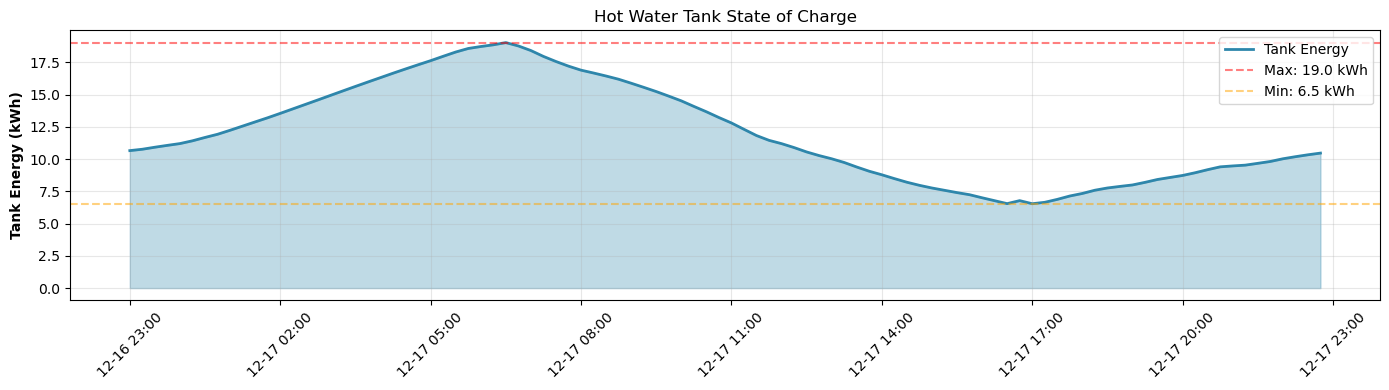

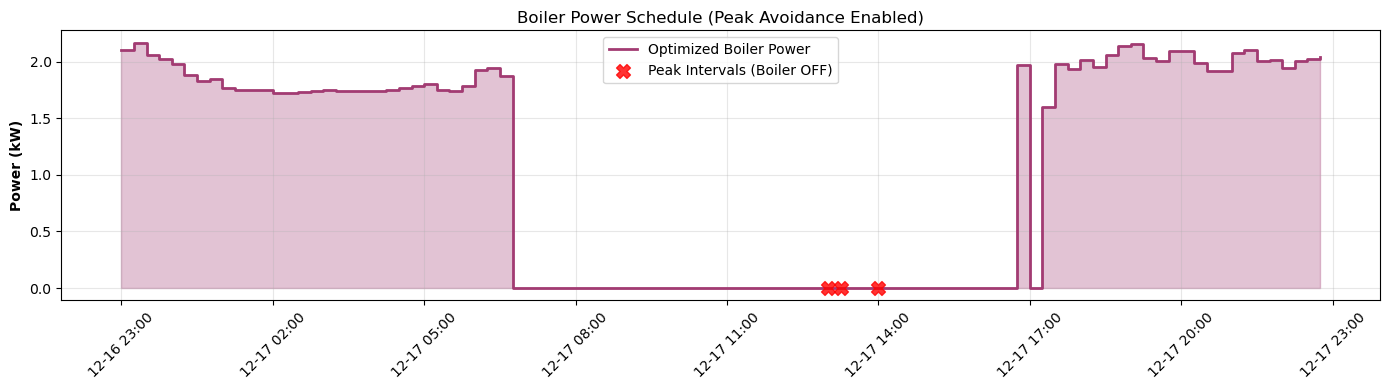

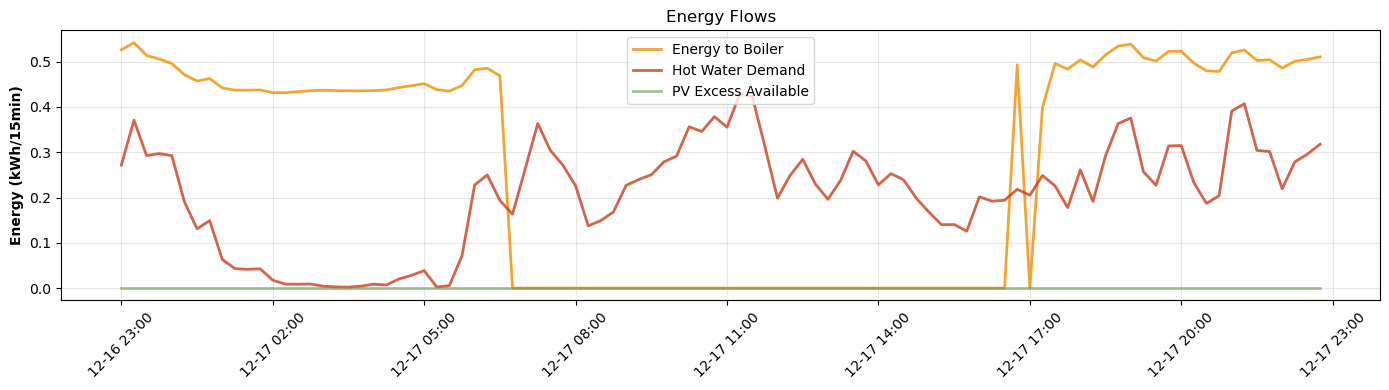

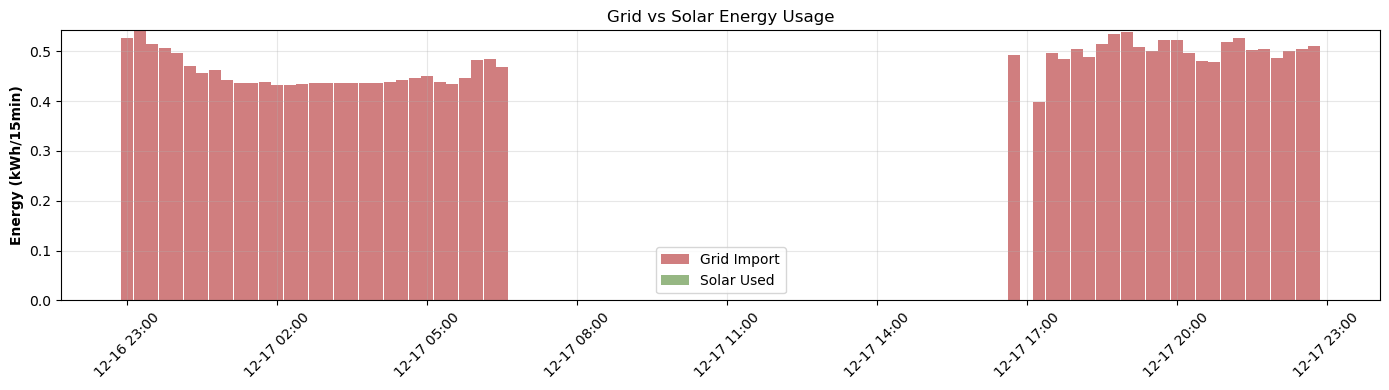

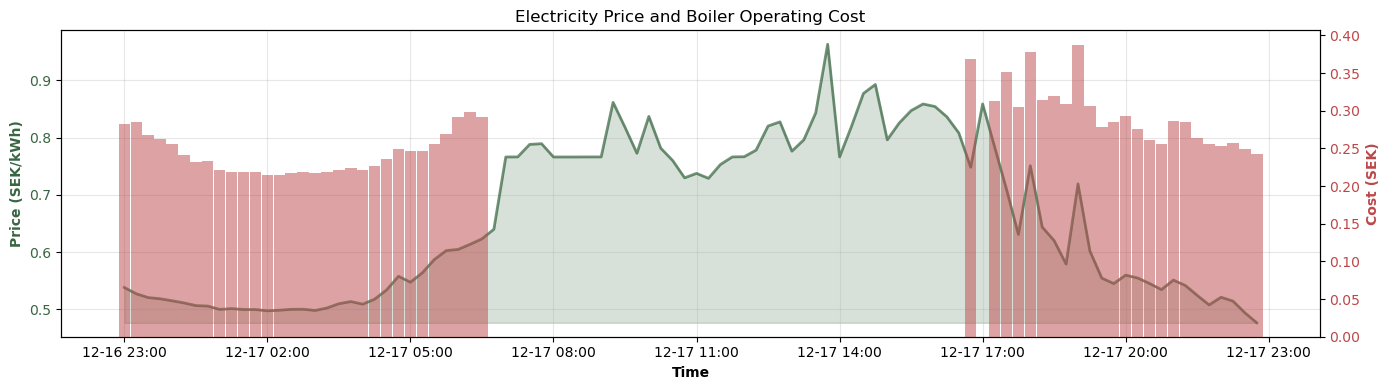

In [3]:
# =====================================================================
# PART 2: VISUALIZATION (each plot in a separate figure)
# =====================================================================

print("\n" + "="*70)
print("PART 2: Generating Visualization (separate figures)")
print("="*70)

# --- Plot 1: Tank Energy State of Charge ---
plt.figure(figsize=(14, 4))
ax1 = plt.gca()
ax1.plot(x_axis, df_all["E_tank_kWh_opt"], linewidth=2, color="#2E86AB",
         label="Tank Energy")
ax1.axhline(y=df_all["E_tank_kWh_opt"].max(), color="red", linestyle="--",
            alpha=0.5, label=f"Max: {df_all['E_tank_kWh_opt'].max():.1f} kWh")
ax1.axhline(y=df_all["E_tank_kWh_opt"].min(), color="orange", linestyle="--",
            alpha=0.5, label=f"Min: {df_all['E_tank_kWh_opt'].min():.1f} kWh")
ax1.fill_between(x_axis, 0, df_all["E_tank_kWh_opt"], alpha=0.3, color="#2E86AB")
ax1.set_ylabel("Tank Energy (kWh)", fontweight="bold")
ax1.set_title("Hot Water Tank State of Charge")
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)
if use_time:
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    plt.xticks(rotation=45)
plt.tight_layout()

# --- Plot 2: Boiler Power Schedule ---
plt.figure(figsize=(14, 4))
ax2 = plt.gca()
ax2.step(x_axis, df_all["P_boil_kW_opt"], where="post", linewidth=2,
         color="#A23B72", label="Optimized Boiler Power")
ax2.fill_between(x_axis, 0, df_all["P_boil_kW_opt"],
                 step="post", alpha=0.3, color="#A23B72")

if "Is_Peak_Interval" in df_all.columns:
    peak_mask = df_all["Is_Peak_Interval"] == 1
    if peak_mask.any():
        ax2.scatter(x_axis[peak_mask], [0]*peak_mask.sum(),
                    color="red", s=100, marker="X", zorder=5,
                    label="Peak Intervals (Boiler OFF)", alpha=0.8)

ax2.set_ylabel("Power (kW)", fontweight="bold")
ax2.set_title("Boiler Power Schedule (Peak Avoidance Enabled)")
ax2.legend(loc="best")
ax2.grid(True, alpha=0.3)
if use_time:
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    plt.xticks(rotation=45)
plt.tight_layout()


# --- Plot 3: Energy Flows ---
plt.figure(figsize=(14, 4))
ax3 = plt.gca()
ax3.plot(x_axis, df_all["Ein_kWh_opt"], linewidth=2,
         color="#F18F01", label="Energy to Boiler", alpha=0.8)
ax3.plot(x_axis, df_all["Boiler_kWh_per_15min"], linewidth=2,
         color="#C73E1D", label="Hot Water Demand", alpha=0.8)
if "PV_excess_kWh_15" in df_all.columns:
    ax3.plot(x_axis, df_all["PV_excess_kWh_15"], linewidth=2,
             color="#6A994E", label="PV Excess Available", alpha=0.6)
ax3.set_ylabel("Energy (kWh/15min)", fontweight="bold")
ax3.set_title("Energy Flows")
ax3.legend(loc="best")
ax3.grid(True, alpha=0.3)
if use_time:
    ax3.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    plt.xticks(rotation=45)
plt.tight_layout()


# --- Plot 4: Grid vs Solar Usage ---
plt.figure(figsize=(14, 4))
ax4 = plt.gca()
bar_width = 0.01 if use_time else 0.8
ax4.bar(x_axis, df_all["Grid_kWh_opt"], width=bar_width,
        color="#BC4749", alpha=0.7, label="Grid Import")
if "PV_excess_kWh_15" in df_all.columns:
    pv_used = (df_all["Ein_kWh_opt"] - df_all["Grid_kWh_opt"]).clip(lower=0)
    ax4.bar(x_axis, pv_used, width=bar_width,
            color="#6A994E", alpha=0.7, label="Solar Used",
            bottom=df_all["Grid_kWh_opt"])
ax4.set_ylabel("Energy (kWh/15min)", fontweight="bold")
ax4.set_title("Grid vs Solar Energy Usage")
ax4.legend(loc="best")
ax4.grid(True, alpha=0.3)
if use_time:
    ax4.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    plt.xticks(rotation=45)
plt.tight_layout()


# --- Plot 5: Electricity Price and Cost ---
plt.figure(figsize=(14, 4))
ax5 = plt.gca()
ax5_twin = ax5.twinx()
ax5.plot(x_axis, df_all["Price_SEK_kWh"], linewidth=2,
         color="#386641", label="Electricity Price", alpha=0.7)
ax5.fill_between(x_axis, df_all["Price_SEK_kWh"].min(),
                 df_all["Price_SEK_kWh"],
                 alpha=0.2, color="#386641")
ax5_twin.bar(x_axis, df_all["Cost_SEK_opt"], width=bar_width,
             color="#BC4749", alpha=0.5, label="Cost per Interval")
ax5.set_ylabel("Price (SEK/kWh)", fontweight="bold", color="#386641")
ax5_twin.set_ylabel("Cost (SEK)", fontweight="bold", color="#BC4749")
ax5.set_xlabel("Time" if use_time else "Time Slot", fontweight="bold")
ax5.set_title("Electricity Price and Boiler Operating Cost")
ax5.tick_params(axis="y", labelcolor="#386641")
ax5_twin.tick_params(axis="y", labelcolor="#BC4749")
ax5.grid(True, alpha=0.3)
if use_time:
    ax5.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



PART 3: Generating TRIAC Minute-Level Control Pattern
✓ Saved TRIAC pattern to boiler_minute_triac_pattern.csv
✓ Total minutes: 1440
✓ Boiler ON minutes: 737 (51.2%)
✓ Average power when ON: 1.91 kW
✓ Available power levels: [0.  0.5 1.1 1.4 1.8 2.2] kW

Generating TRIAC duty cycle visualization...
✓ Saved TRIAC visualization: triac_duty_cycle_pattern.png


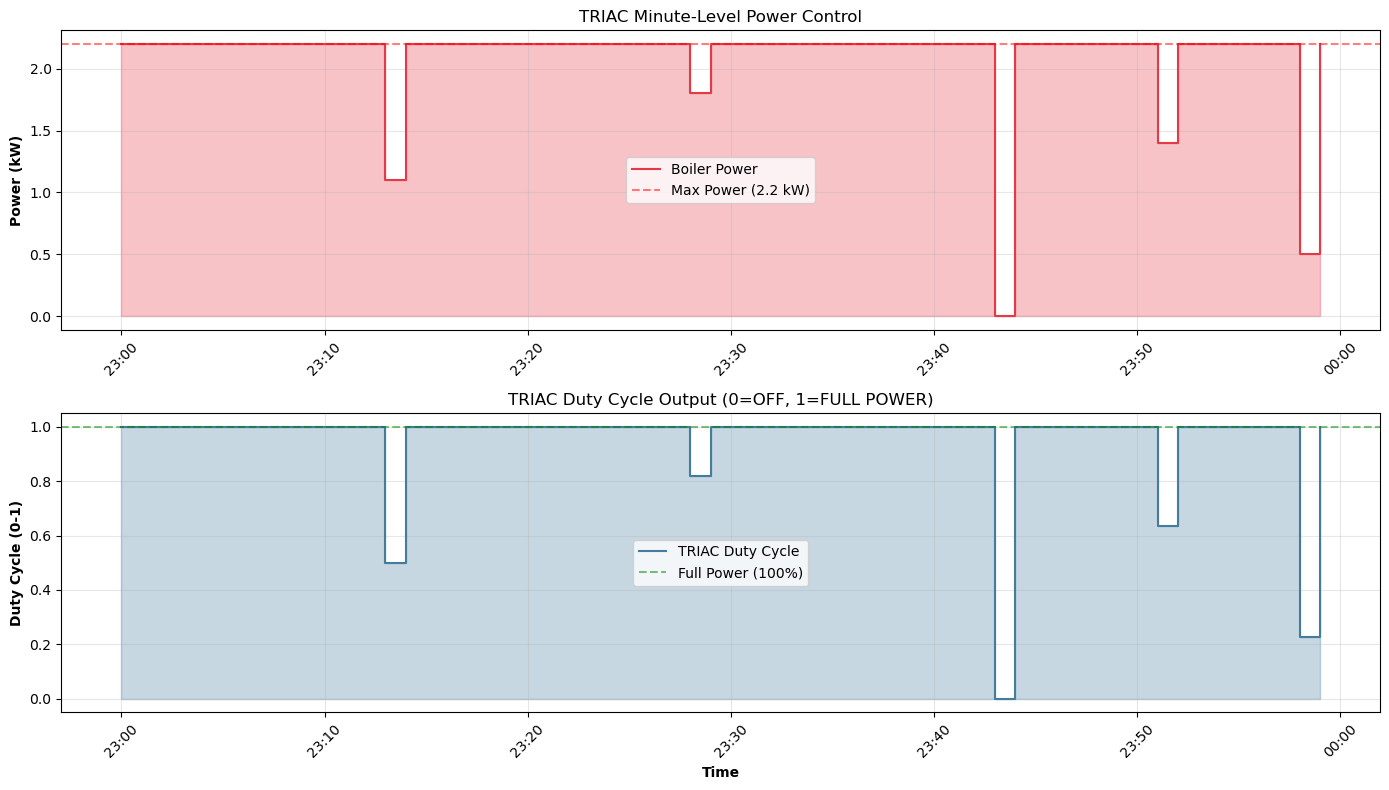

In [4]:
# ============================================================================
# PART 3: TRIAC MINUTE-LEVEL PATTERN GENERATION
# ============================================================================

print("\n" + "="*70)
print("PART 3: Generating TRIAC Minute-Level Control Pattern")
print("="*70)

def attach_triac_minute_pattern(df_all, slot_col="Ein_kWh_opt", 
                               P_max=P_MAX_kW, dt_h=dt_h, 
                               filename='boiler_minute_triac_pattern.csv'):
    """
    Convert 15-minute energy slots into minute-by-minute TRIAC duty cycles.
    
    Parameters:
    -----------
    df_all : DataFrame with optimization results
    slot_col : Column containing energy per 15-min slot (kWh)
    P_max : Maximum boiler power (kW)
    dt_h : Time slot duration (hours)
    filename : Output CSV filename
    
    Returns:
    --------
    DataFrame with minute-level TRIAC patterns
    """
    LEVELS_kW = np.array([0.0, 0.5, 1.1, 1.4, 1.8, P_max])
    N = len(df_all)
    minutes_per_slot = int(dt_h * 60)

    def minute_pattern(Ein_kWh_slot, levels_kW=LEVELS_kW):
        """Generate minute-by-minute power pattern for one 15-min slot."""
        minutes = minutes_per_slot
        p = np.zeros(minutes, dtype=float)
        E_left = Ein_kWh_slot

        # Fill with maximum power minutes first
        n_full = int(np.floor(E_left * 60.0 / P_max))
        n_full = min(n_full, minutes)
        if n_full > 0:
            positions = np.linspace(0, minutes-1, n_full, dtype=int)
            p[positions] = P_max
            E_left -= n_full * (P_max / 60.0)

        # Handle remaining energy with partial power level
        if E_left > 1e-9:
            desired_kW = min(P_max, E_left * 60.0)
            set_kW = levels_kW[np.argmin(np.abs(levels_kW - desired_kW))]
            while set_kW / 60.0 - E_left > 1e-9:
                idx = np.where(levels_kW == set_kW)[0][0]
                if idx == 0:
                    set_kW = 0.0
                    break
                set_kW = levels_kW[idx-1]
            k = int(np.argmin(p))
            p[k] = set_kW
            E_left -= set_kW / 60.0

        # Fine-tune to match exact energy target
        delivered = p.sum() / 60.0
        if abs(delivered - Ein_kWh_slot) > 1e-3:
            diff = Ein_kWh_slot - delivered
            if len(levels_kW) > 1:
                step = (levels_kW[1] - levels_kW[0]) / 60.0
                n_steps = int(round(diff / step))
                sign = 1 if n_steps > 0 else -1
                idxs = np.argsort(p) if sign > 0 else np.argsort(-p)
                for idx in idxs:
                    pos = np.where(levels_kW == p[idx])[0][0]
                    nxt = pos + sign
                    if 0 <= nxt < len(levels_kW):
                        p[idx] = levels_kW[nxt]
                        n_steps -= sign
                        if n_steps == 0:
                            break
        return p

    # Generate minute-level patterns for all slots
    p_minute_kW = np.zeros(N * minutes_per_slot, dtype=float)
    for s in range(N):
        slot_val = df_all.loc[s, slot_col]
        p_minute_kW[s*minutes_per_slot:(s+1)*minutes_per_slot] = minute_pattern(slot_val, LEVELS_kW)

    # Calculate TRIAC duty cycle (0.0 to 1.0)
    duty_minute = np.clip(p_minute_kW / P_max, 0.0, 1.0)

    # Create DataFrame with timestamps
    if "Time" in df_all.columns:
        minute_index = []
        for s in range(N):
            base = pd.to_datetime(df_all.loc[s, "Time"])
            minute_index.extend([base + pd.Timedelta(minutes=m) for m in range(minutes_per_slot)])
        triac_df = pd.DataFrame({
            "Time_minute": minute_index,
            "Boiler_kW_min": p_minute_kW,
            "TRIAC_duty": duty_minute
        })
    else:
        triac_df = pd.DataFrame({
            "Boiler_kW_min": p_minute_kW,
            "TRIAC_duty": duty_minute
        })

    triac_df.to_csv(filename, index=False)
    print(f"✓ Saved TRIAC pattern to {filename}")
    
    # Print summary statistics
    total_minutes = len(p_minute_kW)
    on_minutes = np.sum(p_minute_kW > 0)
    avg_power_when_on = np.mean(p_minute_kW[p_minute_kW > 0]) if on_minutes > 0 else 0
    
    print(f"✓ Total minutes: {total_minutes}")
    print(f"✓ Boiler ON minutes: {on_minutes} ({on_minutes/total_minutes*100:.1f}%)")
    print(f"✓ Average power when ON: {avg_power_when_on:.2f} kW")
    print(f"✓ Available power levels: {LEVELS_kW} kW")
    
    return triac_df

# Generate TRIAC patterns
triac_df = attach_triac_minute_pattern(df_all, slot_col="Ein_kWh_opt")

# Visualize a sample of TRIAC duty cycles
print("\nGenerating TRIAC duty cycle visualization...")
fig_triac, (ax_power, ax_duty) = plt.subplots(2, 1, figsize=(14, 8))

# Show sample in first hour (24 hours = 1440 minutes)
sample_minutes = min(60, len(triac_df))
sample_triac = triac_df.head(sample_minutes)

if "Time_minute" in sample_triac.columns:
    x_triac = sample_triac["Time_minute"]
    use_time_triac = True
else:
    x_triac = range(len(sample_triac))
    use_time_triac = False

# Plot 1: Power levels
ax_power.step(x_triac, sample_triac["Boiler_kW_min"], where='post', 
              linewidth=1.5, color='#E63946', label='Boiler Power')
ax_power.fill_between(x_triac, 0, sample_triac["Boiler_kW_min"], 
                       step='post', alpha=0.3, color='#E63946')
ax_power.axhline(y=P_MAX_kW, color='red', linestyle='--', alpha=0.5, 
                 label=f'Max Power ({P_MAX_kW} kW)')
ax_power.set_ylabel('Power (kW)', fontweight='bold')
ax_power.set_title('TRIAC Minute-Level Power Control')
ax_power.legend(loc='best')
ax_power.grid(True, alpha=0.3)

# Plot 2: Duty cycle
ax_duty.step(x_triac, sample_triac["TRIAC_duty"], where='post', 
             linewidth=1.5, color='#457B9D', label='TRIAC Duty Cycle')
ax_duty.fill_between(x_triac, 0, sample_triac["TRIAC_duty"], 
                      step='post', alpha=0.3, color='#457B9D')
ax_duty.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Full Power (100%)')
ax_duty.set_ylabel('Duty Cycle (0-1)', fontweight='bold')
ax_duty.set_xlabel('Time' if use_time_triac else 'Minute', fontweight='bold')
ax_duty.set_title('TRIAC Duty Cycle Output (0=OFF, 1=FULL POWER)')
ax_duty.legend(loc='best')
ax_duty.grid(True, alpha=0.3)

if use_time_triac:
    ax_power.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax_duty.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax_power.tick_params(axis='x', rotation=45)
    ax_duty.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('triac_duty_cycle_pattern.png', dpi=300, bbox_inches='tight')
print("✓ Saved TRIAC visualization: triac_duty_cycle_pattern.png")
plt.show()



In [5]:
triac_df

,Time_minute,Boiler_kW_min,TRIAC_duty
0,2025-12-17 00:00:00+01:00,2.2,1.000000
1,2025-12-17 00:01:00+01:00,2.2,1.000000
2,2025-12-17 00:02:00+01:00,2.2,1.000000
3,2025-12-17 00:03:00+01:00,2.2,1.000000
4,2025-12-17 00:04:00+01:00,2.2,1.000000
...,...,...,...
1435,2025-12-17 23:55:00+01:00,1.8,0.818182
1436,2025-12-17 23:56:00+01:00,1.8,0.818182
1437,2025-12-17 23:57:00+01:00,1.8,0.818182
1438,2025-12-17 23:58:00+01:00,0.0,0.000000


In [6]:
triac_df.to_csv("triac_schedule.csv", index=False)
